In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
sys.path.append('../../../src/vae')
sys.path.append('../../../src/dsets/gaussian_mixture')
sys.path.append('../')
from dset import get_dataloaders
from model import init_specific_model
from losses import Loss
from training import Trainer
from utils import plot_2d_samples, plot_2d_latent_samples, plot_traversals
import pickle as pkl
import pandas as pd
import seaborn as sns
from sim_gaussian_mixture import p, define_dataloaders

In [2]:
dirs = ["vary_lamPT_beta_warmstart_seed=15_2"]
results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj("/home/ubuntu/local-vae/notebooks/ex_gaussian_mixture/results", dirs[i])
    fnames = sorted(os.listdir(out_dir))

    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            model = init_specific_model(orig_dim=results_list[-1]['orig_dim'], 
                                        latent_dim=results_list[-1]['latent_dim'], 
                                        hidden_dim=results_list[-1]['hidden_dim']).to(device)
            model.load_state_dict(torch.load(opj(out_dir, fname)))
            models_list.append(model)
            
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

## Plotting results

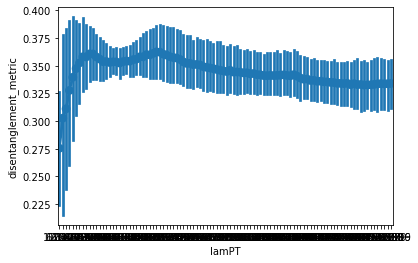

In [3]:
ax = sns.pointplot(x="lamPT", y="disentanglement_metric", hue=None, data=results[0])

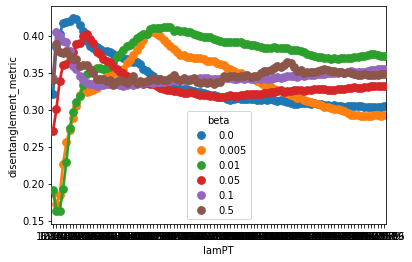

In [22]:
ax = sns.pointplot(x="lamPT", y="disentanglement_metric", hue="beta", data=results[0])

In [7]:
recon_loss = np.array(results[0]['reconstruction_loss'])
kl_loss = np.array(results[0]['kl_normal_loss'])
mu_loss = np.array(results[0]['mu_squared_loss'])
pt_loss = np.array(results[0]['pt_local_independence_loss'])
lam_pt = np.array(results[0]['lamPT'])
beta = np.array(results[0]['beta'])
beta_unique = np.unique(beta)
loss = recon_loss + beta * kl_loss + lam_pt * pt_loss

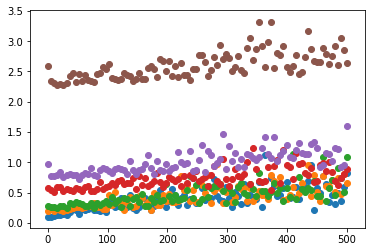

In [8]:
plt.scatter(lam_pt[beta==beta_unique[0]], loss[beta==beta_unique[0]], color='C0')
plt.scatter(lam_pt[beta==beta_unique[1]], loss[beta==beta_unique[1]], color='C1')
plt.scatter(lam_pt[beta==beta_unique[2]], loss[beta==beta_unique[2]], color='C2')
plt.scatter(lam_pt[beta==beta_unique[3]], loss[beta==beta_unique[3]], color='C3')
plt.scatter(lam_pt[beta==beta_unique[4]], loss[beta==beta_unique[4]], color='C4')
plt.scatter(lam_pt[beta==beta_unique[5]], loss[beta==beta_unique[5]], color='C5')

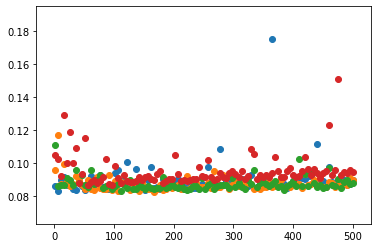

In [13]:
plt.scatter(lam_pt[beta==beta_unique[0]], recon_loss[beta==beta_unique[0]], color='C0')
plt.scatter(lam_pt[beta==beta_unique[1]], recon_loss[beta==beta_unique[1]], color='C1')
plt.scatter(lam_pt[beta==beta_unique[2]], recon_loss[beta==beta_unique[2]], color='C2')
plt.scatter(lam_pt[beta==beta_unique[3]], recon_loss[beta==beta_unique[3]], color='C3')
# plt.scatter(lam_pt[beta==beta_unique[4]], recon_loss[beta==beta_unique[4]], color='C4')
# plt.scatter(lam_pt[beta==beta_unique[5]], recon_loss[beta==beta_unique[5]], color='C5')

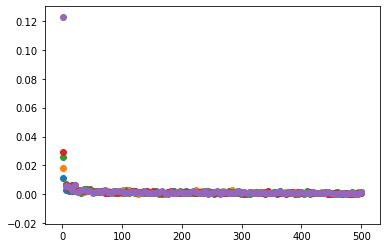

In [21]:
plt.scatter(lam_pt[beta==beta_unique[0]], pt_loss[beta==beta_unique[0]], color='C0')
plt.scatter(lam_pt[beta==beta_unique[1]], pt_loss[beta==beta_unique[1]], color='C1')
plt.scatter(lam_pt[beta==beta_unique[2]], pt_loss[beta==beta_unique[2]], color='C2')
plt.scatter(lam_pt[beta==beta_unique[3]], pt_loss[beta==beta_unique[3]], color='C3')
# plt.scatter(lam_pt[beta==beta_unique[4]], pt_loss[beta==beta_unique[4]], color='C4')
# plt.scatter(lam_pt[beta==beta_unique[5]], pt_loss[beta==beta_unique[5]], color='C5')

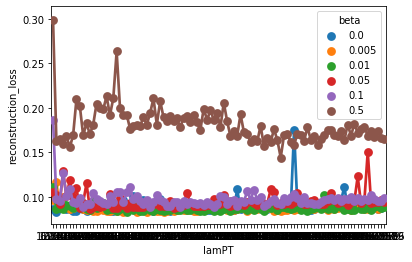

In [5]:
ax = sns.pointplot(x="lamPT", y="reconstruction_loss", hue="beta", data=results[0])

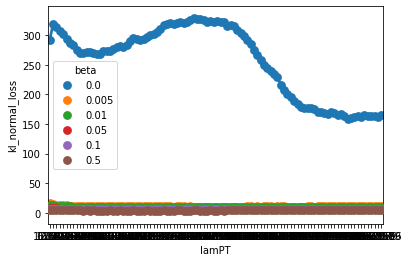

In [6]:
ax = sns.pointplot(x="lamPT", y="kl_normal_loss", hue="beta", data=results[0])

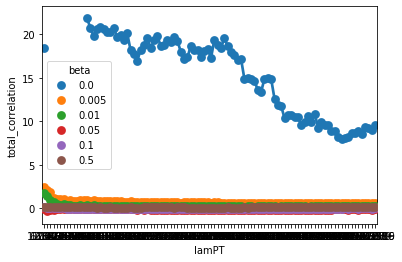

In [7]:
ax = sns.pointplot(x="lamPT", y="total_correlation", hue="beta", data=results[0])

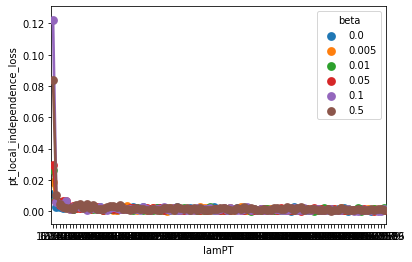

In [8]:
ax = sns.pointplot(x="lamPT", y="pt_local_independence_loss", hue="beta", data=results[0])

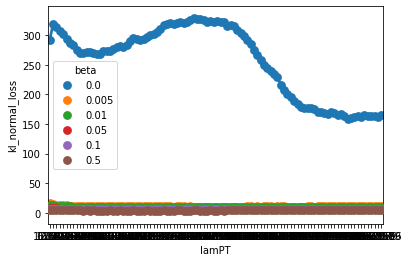

In [9]:
ax = sns.pointplot(x="lamPT", y="kl_normal_loss", hue="beta", data=results[0])

## Visualization

disentanglement metric: 0.163


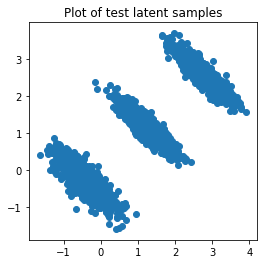

In [10]:
# GET MODEL AND RESULT
idx = np.argmin(np.array(results[0]['disentanglement_metric']))
model = models[0][idx]
result = results[0].loc[idx]
print('disentanglement metric: {:.3f}'.format(result['disentanglement_metric']))

params_to_vary = ['num_epochs', 'seed', 'hidden_dim', 'beta', 'mu', 'lamPT', 'lamCI', 'dirname', 'latent_means', 'latent_vars']
for name in params_to_vary:
    setattr(p, name, result[name])
    
# SEED
random.seed(p.seed)
np.random.seed(p.seed)
torch.manual_seed(p.seed)    

# GET DATALOADERS
(_, _), (test_loader, test_latents) = define_dataloaders(p)

# EVALUATE TEST DATA
data = test_loader.dataset.data.to(device)
recon_data, latent_dist, latent_sample = model(data)
plot_2d_latent_samples(latent_sample)
plt.title("Plot of test latent samples")
plt.show()

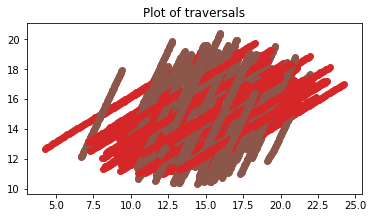

In [11]:
plot_traversals(model, data, lb=1000, ub=2000, num=100, max_traversal=.5)
plt.title("Plot of traversals")
plt.show()

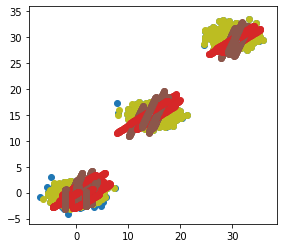

In [14]:
plot_traversals(model, data, lb=0, ub=3000, num=20,
                draw_data=True, draw_recon=True, max_traversal=.5)